**So here is what I am going to try in this notebook , I am going to drop experiment feature and keep the time feature as it is. I am simply going to train my model on this data as it is and see the results on the best model.**

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597053235&Signature=LPrAGyUvFAFA7ZkkwUWyc0srI5488quzzTLdj1ThHt3H2isET80a8V6dHQQruHzZHJgRq%2FBF%2BGzLxf0DEaB0HB0iYF2AnxlKcxEU3xbWcdZF9at7J8HOfFNB9t3AezeghzCnu6FAcLvKRTHVJrCJnLBQk6wQgFHxgJPwH3dQeuhnJwEVpkj2rFqBkN2Ray3r2WZeL01xO6VZN8O7zGWg4ORaQikb3I12Vid%2BrN5ubxeljOQ3UfDJ%2B8hDMVMSVu86SHZY6xREyLN5dvMn%2BLK8j98Gzw4a5dXx3F3WdGl3t5a1%2F%2BPB2H54Ge4j6%2F15AB0gwf%2FWmcgi7%2ByDeNB9xAiMDw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip" -c -O 'train.csv.zip'

--2020-08-08 11:48:18--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597053235&Signature=LPrAGyUvFAFA7ZkkwUWyc0srI5488quzzTLdj1ThHt3H2isET80a8V6dHQQruHzZHJgRq%2FBF%2BGzLxf0DEaB0HB0iYF2AnxlKcxEU3xbWcdZF9at7J8HOfFNB9t3AezeghzCnu6FAcLvKRTHVJrCJnLBQk6wQgFHxgJPwH3dQeuhnJwEVpkj2rFqBkN2Ray3r2WZeL01xO6VZN8O7zGWg4ORaQikb3I12Vid%2BrN5ubxeljOQ3UfDJ%2B8hDMVMSVu86SHZY6xREyLN5dvMn%2BLK8j98Gzw4a5dXx3F3WdGl3t5a1%2F%2BPB2H54Ge4j6%2F15AB0gwf%2FWmcgi7%2ByDeNB9xAiMDw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456337398 (435M) [application/zip]
Saving to: ‘train.csv.zip’

train.csv.zi

In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
import dask.dataframe as dd
import dask
import gc

from yellowbrick.text import TSNEVisualizer

%matplotlib inline
plt.style.use("fivethirtyeight")
warnings.filterwarnings(action='ignore')
sns.set_style('whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# This is to be used for memory optimization because the data is very large.
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
              df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
def featureModify(isTrain, numRows):
    if isTrain:
        df = dd.read_csv('train.csv',nrows=numRows) 
        df = df.compute()
        # df['pilot'] = 100*df['crew']+df['seat']
        df = reduce_mem_usage(df)
        df['event'] = df['event'].map({
            'A':0,
            'B':1,
            'C':2,
            'D':3
        })
    else:
        df = dd.read_csv('test.csv',nrows=numRows)
        df = df.compute()
        # df['pilot'] = 100*df['crew']+df['seat']
        df = reduce_mem_usage(df)
    
    return df 
# train = featureModify(True, None)
# y = train['event']
# train = train.drop('event',axis=1)
# print(train.shape)
# print(train.columns)

In [ ]:
# I didnt do this for LightGBM
train = train.drop(columns=['experiment'],axis=1)

In [ ]:
col = train.columns

In [ ]:
# I have used this normalisation only for naive bayes
# from sklearn.preprocessing import MinMaxScaler
# ms = MinMaxScaler()
# train = ms.fit_transform(train)

In [ ]:
train = pd.DataFrame(train)

In [ ]:
train.columns = col

In [ ]:
train.head()

,crew,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,1,0.011719,1,-5.285156,26.781250,-9.523438,-12.796875,16.718750,33.75000,23.718750,-6.695312,29.234375,24.843750,3.921875,18.453125,1.075195,3.089844,37.375000,17.437500,19.203125,20.593750,-3.951172,14.507812,-4520.0,817.5,388.75
1,1,0.015625,1,-2.427734,28.437500,-9.320312,-3.757812,15.968750,30.43750,21.015625,-6.476562,26.640625,24.140625,5.468750,20.515625,2.833984,7.101562,31.171875,19.406250,19.687500,21.359375,1.332031,17.750000,-4520.0,817.5,388.75
2,1,0.019531,1,10.671875,30.421875,15.351562,24.718750,16.140625,32.15625,25.437500,-0.088684,28.125000,26.890625,8.578125,23.156250,4.519531,12.703125,-12.015625,19.390625,23.171875,22.406250,1.538086,22.250000,-4520.0,817.5,388.75
3,1,0.023438,1,11.453125,25.609375,2.433594,12.414062,20.531250,31.50000,19.140625,-0.256592,30.656250,24.250000,8.640625,19.968750,7.277344,11.460938,18.578125,23.156250,22.640625,19.343750,2.544922,19.000000,-4520.0,817.5,388.75
4,1,0.027344,1,7.285156,25.937500,0.113586,5.746094,19.828125,28.75000,20.578125,-1.953125,31.718750,25.156250,12.500000,18.750000,7.308594,8.007812,6.554688,22.750000,22.671875,20.296875,1.699219,22.812500,-4520.0,817.5,388.75


# ***Naive Bayes***

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size =0.2, random_state=40)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3893936, 26)
(973485, 26)
(3893936,)
(973485,)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV 
param_dist = {"alpha" :[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1]} 
nb = MultinomialNB()
rsc = RandomizedSearchCV(nb,param_dist,cv=4,verbose=500)
rsc.fit(X_train,y_train)
print("Tuned Multinomial Niave Bayes Parameters: {}".format(rsc.best_params_)) 
print("Best score is {}".format(rsc.best_score_)) 

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=1e-07 .....................................................
[CV] ......................... alpha=1e-07, score=0.585, total=   2.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[CV] alpha=1e-07 .....................................................
[CV] ......................... alpha=1e-07, score=0.585, total=   2.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s
[CV] alpha=1e-07 .....................................................
[CV] ......................... alpha=1e-07, score=0.585, total=   2.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[CV] alpha=1e-07 .....................................................
[CV] ......................... alpha=1e-07, score=0.585, total=   2.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

In [ ]:
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix
clf = MultinomialNB(alpha=1e-07)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict_proba(X_test)
print(log_loss(y_test,y_pred))

0.9223443374768153


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
from sklearn.model_selection import RandomizedSearchCV 
# from sklearn.multiclass import OneVsRestClassifier
param_dist = {"C" : [0.001,0.01,0.1,1,10]}
lr = LogisticRegression(multi_class='ovr')
rsc = RandomizedSearchCV(lr,param_dist,cv=2,verbose=500,n_jobs=1)
rsc.fit(X_train,y_train)
print("Tuned Logistic Regression Parameters: {}".format(rsc.best_params_)) 
print("Best score is {}".format(rsc.best_score_)) 

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.583, total= 2.4min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.583, total= 2.5min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.583, total= 2.4min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.3min remaining:    0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.582, total= 2.4min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

In [ ]:
clf = LogisticRegression(multi_class='ovr',C = 0.01)
clf = clf.fit(X_train,y_train)
pred= clf.predict_proba(X_test)
print(log_loss(y_test,pred))

0.9206174913509789


# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm
max_depth =  [10,100,200,300]
for i in tqdm(max_depth):
  print('depth is',i)
  clf = DecisionTreeClassifier(max_depth=i)
  clf.fit(X_train,y_train)
  y_pred = clf.predict_proba(X_test)
  print(log_loss(y_test,y_pred))

depth is 10
0.49245480396760244
depth is 100
0.04200774665411109
depth is 200
0.04179486955958013
depth is 300
0.042185144232886884



Okay so we observed that the optimum depth size is 200 since it gives us least loss


I am taking the reference of the hyperparamter tuning form the previous model building notebook and training the data to see which one gives best result

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV 
param_dist = {"max_depth" : [200], 
              "criterion" : ['entropy'],
              "random_state" : [40],
              "max_features" : ['auto'],
              "max_leaf_nodes" : [1500,2000,2500]
              } 
dtc = DecisionTreeClassifier()
rsc = RandomizedSearchCV(dtc,param_dist,cv=2,verbose=500)
rsc.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(rsc.best_params_)) 
print("Best score is {}".format(rsc.best_score_)) 

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] random_state=40, max_leaf_nodes=1500, max_features=auto, max_depth=200, criterion=entropy 
[CV]  random_state=40, max_leaf_nodes=1500, max_features=auto, max_depth=200, criterion=entropy, score=0.888, total=  22.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.2s remaining:    0.0s
[CV] random_state=40, max_leaf_nodes=1500, max_features=auto, max_depth=200, criterion=entropy 
[CV]  random_state=40, max_leaf_nodes=1500, max_features=auto, max_depth=200, criterion=entropy, score=0.873, total=  22.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.0s remaining:    0.0s
[CV] random_state=40, max_leaf_nodes=2000, max_features=auto, max_depth=200, criterion=entropy 
[CV]  random_state=40, max_leaf_nodes=2000, max_features=auto, max_depth=200, criterion=entropy, score=0.898, total=  23.2s
[Parallel(n_jobs=1)]: Done   3 out of   

In [ ]:
clf = DecisionTreeClassifier(max_depth = 200, criterion= 'entropy', max_leaf_nodes = None, random_state = 40)
clf = clf.fit(X_train,y_train)
pred = clf.predict_proba(X_test)


NameError: ignored

In [ ]:
print(log_loss(y_test,pred))

0.021429627516119047


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 200,criterion = 'entropy', random_state=40)
clf.fit(X_train,y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=200, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

In [ ]:
import joblib
# joblib.dump(clf,'decision_tree.pkl')

['decision_tree.pkl']

In [ ]:
import joblib
clf = joblib.load('decision_tree.pkl')
# clf.predict_pro

In [ ]:
y_pred = clf.predict_proba(test)

# **LightGBM**

For Lightgbm I am not dropping the experiment feature since the I tried it by dropping that feature but I didnt get very good result.

In [ ]:
train, train_test, y, y_test = train_test_split(train, y, test_size=0.25, shuffle=False)
train = lgb.Dataset(train, label=y,categorical_feature=[1])
del y
gc.collect()


train_test = lgb.Dataset(train_test, label=y_test,categorical_feature=[1])
del y_test
gc.collect()

0

In [ ]:
params = {
        "objective" : "multiclass", 
        "metric" : "multi_error", 
        'num_class':4,
        "num_leaves" : 30, 
        "learning_rate" : 0.01, 
        "bagging_fraction" : 0.9,
        "bagging_seed" : 0, 
        "num_threads" : 4,
        "colsample_bytree" : 0.5,
        'min_data_in_leaf':100, 
        'min_split_gain':0.00019
}
model = lgb.train(  params, 
                    train_set = train,
                    num_boost_round=2000,
                    early_stopping_rounds=200,
                    verbose_eval=100, 
                    valid_sets=[train,train_test]
                  )

Training until validation scores don't improve for 200 rounds.
[100]	training's multi_error: 0.0732298	valid_1's multi_error: 0.150007
[200]	training's multi_error: 0.0513315	valid_1's multi_error: 0.0836788
[300]	training's multi_error: 0.0446361	valid_1's multi_error: 0.0819834
[400]	training's multi_error: 0.0376761	valid_1's multi_error: 0.0810803
[500]	training's multi_error: 0.0339035	valid_1's multi_error: 0.0818256
Early stopping, best iteration is:
[392]	training's multi_error: 0.0380341	valid_1's multi_error: 0.08098


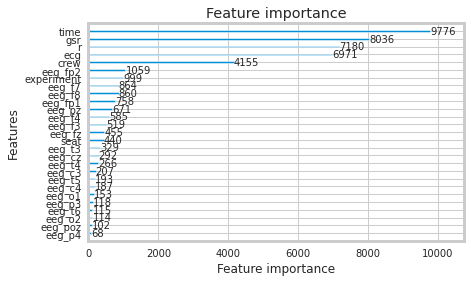

In [ ]:
lgb.plot_importance(model)

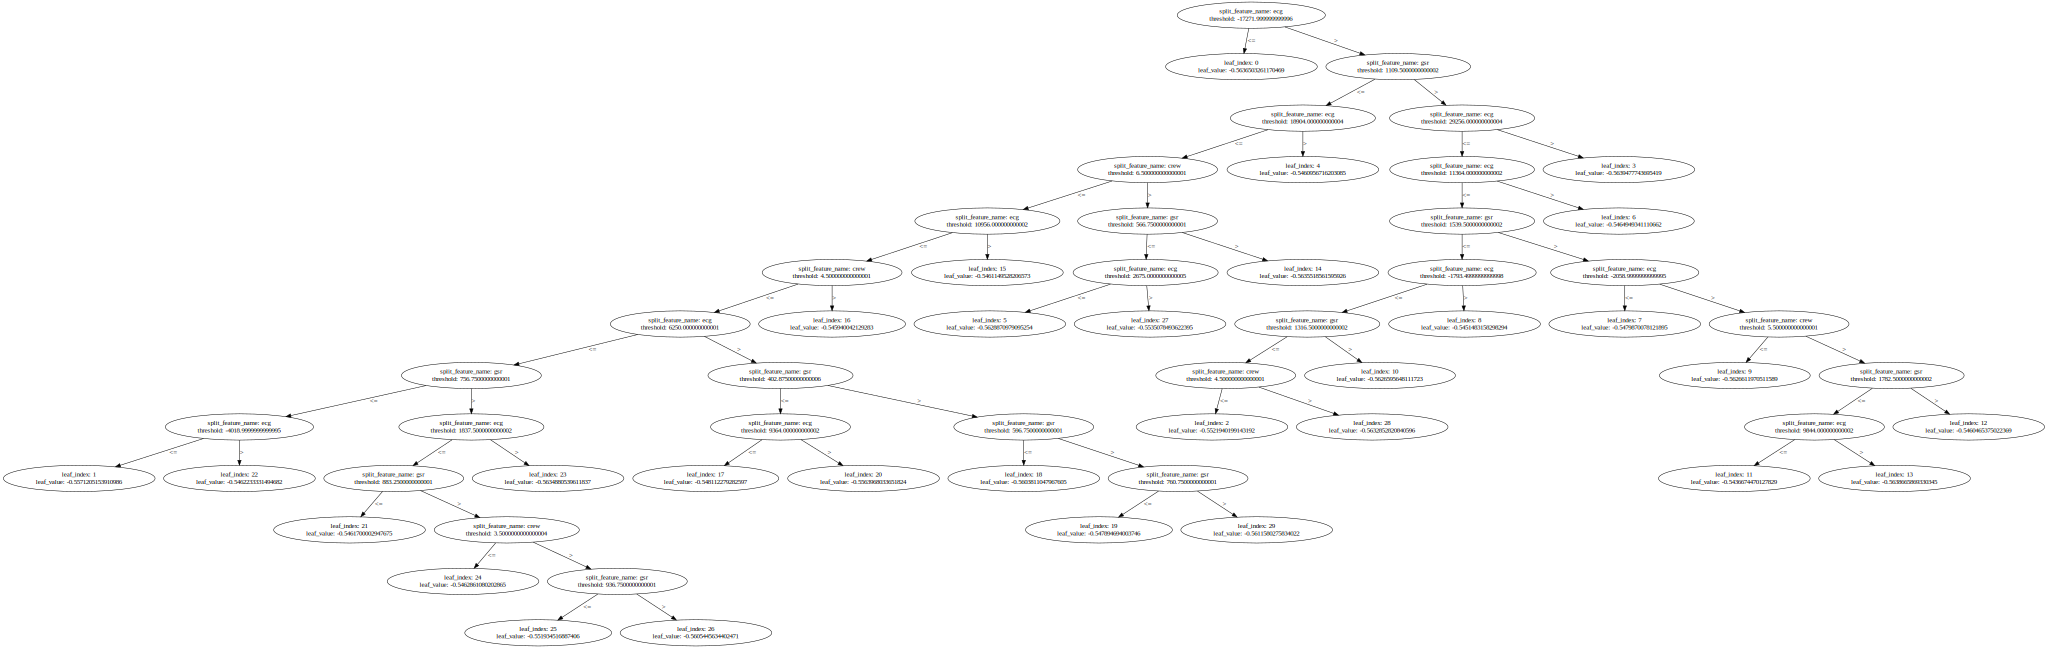

In [ ]:
lgb.create_tree_digraph(model)

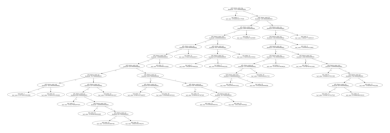

In [ ]:
lgb.plot_tree(model)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/ML case study/models')

In [ ]:
import joblib 
joblib.dump(model,'Model_building_LGB(1).pkl')

['Model_building_LGB(1).pkl']

In [ ]:
import joblib 
model =joblib.load('Model_building_LGB(1).pkl')

In [ ]:
os.chdir('/content')

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597062299&Signature=sSEFif%2Bviyz4WtNlQ0YoOIKIdFcDpMHNbPp6WC0PyglcoixHb3mbDv90BDKUgfaGHRdlNL5jZdlYFSKTabezCGvWs2GLuvwjD5b2DyS6lOXgv1zJDoEYiZSaw2P3oCCRjSJKQKv5GZeHEXa4go%2FpMg4jzDFh%2BCnTxCPdFeYntOBu%2F8NgEe7ntcLUDvbtzn%2BwIrBuud1RDDVyBuv2fNTuzoQLgDvM2U%2B6NzaYZVzkEbxvGJRcieT7b0RxegoC3LRpl%2Bk0WPXo6Qy4qq7quVNix%2FjvkjPhXz2txIj27sGcn%2Bg%2FGP8OKCvWitUAPnry7ngQLMxwdhyMASE4iXIkRl4dGA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip" -c -O 'test.csv.zip'

--2020-08-08 11:57:06--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597062299&Signature=sSEFif%2Bviyz4WtNlQ0YoOIKIdFcDpMHNbPp6WC0PyglcoixHb3mbDv90BDKUgfaGHRdlNL5jZdlYFSKTabezCGvWs2GLuvwjD5b2DyS6lOXgv1zJDoEYiZSaw2P3oCCRjSJKQKv5GZeHEXa4go%2FpMg4jzDFh%2BCnTxCPdFeYntOBu%2F8NgEe7ntcLUDvbtzn%2BwIrBuud1RDDVyBuv2fNTuzoQLgDvM2U%2B6NzaYZVzkEbxvGJRcieT7b0RxegoC3LRpl%2Bk0WPXo6Qy4qq7quVNix%2FjvkjPhXz2txIj27sGcn%2Bg%2FGP8OKCvWitUAPnry7ngQLMxwdhyMASE4iXIkRl4dGA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1791131386 (1.7G) [application/zip]
Saving to: ‘test.csv.zip’

test.csv.zip  

In [ ]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
test = featureModify(False, None)
print("Done test read")

Memory usage of dataframe is 3974.83 MB
Memory usage after optimization is: 1079.37 MB
Decreased by 72.8%
Done test read


In [ ]:
test.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.906250,6.128906,0.994629,-28.203125,-47.687500,-187.125000,-33.187500,-4.222656,8.179688,33.156250,33.812500,21.750000,16.296875,-7.042969,-14.406250,-4.035156,-0.393799,31.843750,17.078125,-8.140625,-7324.0,643.0,595.00
1,1,1,LOFT,0.000000,1,45.875000,94.750000,23.296875,1.391602,2.060547,-5.144531,6.394531,33.406250,-295.000000,8.375000,29.640625,16.218750,850.500000,19.890625,-215.125000,2.119141,7.339844,9.664062,1169.000000,-0.024414,-3336.0,826.5,136.25
2,2,1,LOFT,0.003906,0,33.125000,28.359375,-7.238281,-7.691406,-25.828125,-107.250000,12.843750,1.214844,13.320312,44.437500,37.593750,29.078125,22.312500,-7.640625,-10.367188,10.953125,6.511719,36.031250,24.359375,0.956055,-7324.0,643.0,595.00
3,3,1,LOFT,0.003906,1,43.281250,95.875000,18.703125,-1.432617,-4.234375,-8.023438,7.425781,27.343750,-310.250000,5.390625,27.734375,7.218750,816.500000,13.828125,-214.250000,-4.914062,3.503906,3.878906,1159.000000,-0.047607,-3336.0,826.5,136.25
4,4,1,LOFT,0.007812,0,7.929688,3.460938,-10.859375,-26.359375,-25.890625,37.000000,-50.343750,-11.679688,-1.143555,-17.593750,34.062500,22.906250,19.031250,2.044922,-20.781250,-3.613281,-7.539062,3.083984,13.648438,1.473633,-7324.0,643.0,595.00


In [ ]:
df_sub = pd.DataFrame()
df_sub['id'] = test['id']
test = test.drop('id',axis=1)

In [ ]:
test.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,1,LOFT,0.000000,0,17.906250,6.128906,0.994629,-28.203125,-47.687500,-187.125000,-33.187500,-4.222656,8.179688,33.156250,33.812500,21.750000,16.296875,-7.042969,-14.406250,-4.035156,-0.393799,31.843750,17.078125,-8.140625,-7324.0,643.0,595.00
1,1,LOFT,0.000000,1,45.875000,94.750000,23.296875,1.391602,2.060547,-5.144531,6.394531,33.406250,-295.000000,8.375000,29.640625,16.218750,850.500000,19.890625,-215.125000,2.119141,7.339844,9.664062,1169.000000,-0.024414,-3336.0,826.5,136.25
2,1,LOFT,0.003906,0,33.125000,28.359375,-7.238281,-7.691406,-25.828125,-107.250000,12.843750,1.214844,13.320312,44.437500,37.593750,29.078125,22.312500,-7.640625,-10.367188,10.953125,6.511719,36.031250,24.359375,0.956055,-7324.0,643.0,595.00
3,1,LOFT,0.003906,1,43.281250,95.875000,18.703125,-1.432617,-4.234375,-8.023438,7.425781,27.343750,-310.250000,5.390625,27.734375,7.218750,816.500000,13.828125,-214.250000,-4.914062,3.503906,3.878906,1159.000000,-0.047607,-3336.0,826.5,136.25
4,1,LOFT,0.007812,0,7.929688,3.460938,-10.859375,-26.359375,-25.890625,37.000000,-50.343750,-11.679688,-1.143555,-17.593750,34.062500,22.906250,19.031250,2.044922,-20.781250,-3.613281,-7.539062,3.083984,13.648438,1.473633,-7324.0,643.0,595.00


In [ ]:
import joblib
model = joblib.load('/content/drive/My Drive/ML case study/models/Model_building_LGB(1).pkl')

In [ ]:
y_pred = model.predict(test,num_iteration=model.best_iteration)

In [ ]:
y_pred

array([[0.97357333, 0.00215279, 0.02030727, 0.00396661],
       [0.96985874, 0.00287824, 0.02312566, 0.00413735],
       [0.97360533, 0.00219119, 0.02011564, 0.00408784],
       ...,
       [0.88274026, 0.00318973, 0.10606072, 0.00800928],
       [0.94154287, 0.00231302, 0.04893579, 0.00720831],
       [0.88331155, 0.00313693, 0.10554946, 0.00800207]])

In [ ]:
import os
os.chdir('/content/drive/My Drive/ML case study/results')

In [ ]:
import joblib
joblib.dump(y_pred,'Model_building5_LGB_output(1).pkl')

['Model_building5_LGB_output(1).pkl']

In [ ]:
import joblib 
y_pred = joblib.load('/content/drive/My Drive/ML case study/results/Model_building5_LGB_output(1).pkl')

In [ ]:
y_pred

array([[0.97357333, 0.00215279, 0.02030727, 0.00396661],
       [0.96985874, 0.00287824, 0.02312566, 0.00413735],
       [0.97360533, 0.00219119, 0.02011564, 0.00408784],
       ...,
       [0.88274026, 0.00318973, 0.10606072, 0.00800928],
       [0.94154287, 0.00231302, 0.04893579, 0.00720831],
       [0.88331155, 0.00313693, 0.10554946, 0.00800207]])

In [ ]:
import os 
os.chdir('/content/drive/My Drive/ML case study/results/')

In [ ]:
df_sub = pd.DataFrame(np.concatenate((np.arange(len(test))[:, np.newaxis], y_pred), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
df_sub['id'] = df_sub['id'].astype(int)
print(df_sub)
df_sub.to_csv("Model_building5_LGBop.csv", index=False)

                id         A         B         C         D
0                0  0.973573  0.002153  0.020307  0.003967
1                1  0.969859  0.002878  0.023126  0.004137
2                2  0.973605  0.002191  0.020116  0.004088
3                3  0.969847  0.002912  0.023105  0.004136
4                4  0.974038  0.002179  0.019839  0.003944
...            ...       ...       ...       ...       ...
17965138  17965138  0.882729  0.003132  0.106111  0.008028
17965139  17965139  0.941786  0.002305  0.048648  0.007261
17965140  17965140  0.882740  0.003190  0.106061  0.008009
17965141  17965141  0.941543  0.002313  0.048936  0.007208
17965142  17965142  0.883312  0.003137  0.105549  0.008002

[17965143 rows x 5 columns]


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
param_dist = {"n_estimators":[1,5,10],
              "max_depth" : [200], 
              "criterion" : ['entropy'],
              "random_state" : [40],
              "max_features" : ['auto'],
              } 
rfc = RandomForestClassifier()
rsc = RandomizedSearchCV(rfc,param_dist,cv=2,verbose=500)
rsc.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(rsc.best_params_)) 
print("Best score is {}".format(rsc.best_score_)) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
n_estimators =  [10,25,50]
for i in tqdm(n_estimators):
  print('n_estimators are:',i)
  clf = RandomForestClassifier(n_estimators=i,max_depth=200,criterion='entropy')
  clf.fit(X_train,y_train)
  y_pred = clf.predict_proba(X_test)
  print('Log_loss is:',(log_loss(y_test,y_pred)))

n_estimators are: 10
Log_loss is: 0.043098855808167656
n_estimators are: 25
Log_loss is: 0.033084208336728135
n_estimators are: 50
Log_loss is: 0.03091853122729293

